In [30]:
%reload_ext autoreload
%autoreload 2

In [51]:
import sys
import os

# Add src directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

from pricing.triple_win import TripleWinPricing, TrackingTripleWinPricing
from pricing.buyer import BuyerBlock
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


In [ ]:
df_shapley = pd.read_csv("../tables/unified_shapley_matrix_10sellers.csv")

selected_columns = []

MODELS_NUM = 10

for i in range(10):
    selected_columns.append(f"seller_{i}")
SV = df_shapley[selected_columns].sample(MODELS_NUM).values.transpose()
SV = SV / SV.sum(axis=0, keepdims=True)


=== Market outcome comparison (USD) ===
              inside_frac feasible_sum_p nominal_sum_p fairness_spearman
TripleWin           0.992        $571.33       $571.24             0.932
DemandFirst         0.992        $139.05       $139.24             0.553
SupplyFirst         0.977      $1,141.52     $1,246.41             0.182
BrokerCentric       0.938      $1,179.62     $1,499.53             0.182

δ values used (all methods): [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


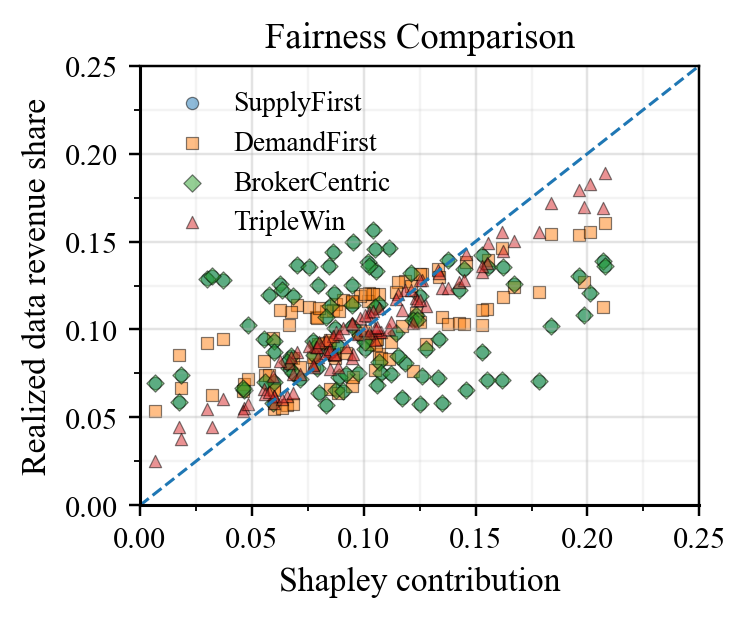

In [ ]:
# ============================================================
#  Market Simulation (USD, realistic ranges)
#  Mechanisms compared: SupplyFirst, DemandFirst, BrokerCentric, TripleWin
#
#  Key clarity points (naming & direction):
#  - Two price layers:
#      * Data→Model edge prices:      p_{D_i→M_j}  (dataset i paid by model j)
#      * Model→Buyer edge prices:     p_{M_j→B_k}  (buyer k pays for model j)
#
#  - Two quotation mappings (who DRIVES the quote vs who SEES the quote):
#      * forward / downstream / buyer-facing, SUPPLY-driven:
#          Q_{B_k→M_j}(p_{D→M}) = κ_{M_j→B_k} + (1+δ_j) * Σ_i p_{D_i→M_j}
#        (Data costs + producer margin → pushed forward to buyers)
#
#      * backward / upstream / seller-facing, DEMAND-driven:
#          Q_{D_i→M_j}(p_{B→M}) = κ_{D_i} + (SV_{i|j}/(1+δ_j)) * Q_j,
#          where Q_j = Σ_k ω_{jk} * p_{M_j→B_k} and Σ_k ω_{jk} ≤ 1
#        (Aggregated buyer bids → allocated back to datasets via Shapley)
#
#  Mechanism definitions (single pass baselines vs fixed point):
#    - SupplyFirst:  set p_{M→B} := Q_{B→M}(p_{D→M}); keep p_{D→M} as-is. (downstream only)
#    - DemandFirst:  set p_{D→M} := Q_{D→M}(p_{M→B}); keep p_{M→B} as-is. (upstream only)
#    - BrokerCentric: platform/producer chooses a heuristic markup α_j (robust variant)
#                     and sets p_{M→B} = κ + (1+α_j)*Σ_i p_{D→M}(i,j). (downstream, buyer-facing)
#    - TripleWin:    iterate both mappings until fixed point p = Q(p) (SIF guarantees).
#
#  Feasibility (acceptance) region used for inside_frac:
#    - Buyer acceptance:  p_{M→B} ≤ R           (no buyer lower bound)
#    - Seller acceptance: p_{D→M} ≥ κ_D         (no seller upper bound)
#    Note: κ_{M→B} and any list cap \bar p_{D→M} are platform policy knobs, not acceptance bounds.
#
#  Goal: Keep TripleWin’s strong fairness & reasonable feasibility, with all knobs defined at top.
# ============================================================

import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ------------------------------------------------------------
# CONFIG — tune everything here
# ------------------------------------------------------------
SEED = 70                  # random seed for reproducibility
I, J = SV.shape      # infer from SV shape


# Producer base margin δ (used by all methods)
DELTA = 0.10

# Data → Model (dataset sellers):
# - dataseller_min_price: lower bound κ_D (operational/privacy/compliance cost)
# - dataseller_max_price: list cap \bar p_{D→M} (for reporting only; not a feasibility bound)
DATA_MIN_RANGE = (0.10, 0.40)   # USD, κ_D ~ [0.10, 0.40]
DATA_MAX_RANGE = (1.50, 4.00)   # USD, list cap per dataset–model edge ~ [1.50, 4.00]

# Model → Buyer (buyers):
# - kappa_mb: per-sale overhead κ_{M→B} (deployment, support, infra)
# - R: buyer reserve (max willingness to pay)
# - rho: sum of ω per model (effective training-time “first-sale share”); Σ_k ω_{jk} = rho ≤ 1
BUYER_KAPPA_RANGE = (1.0, 5.0)        # USD
BUYER_R_RANGE = (25.0, 100.0)         # USD
RHO = 0.6                              # Σ_k ω_{jk} = RHO ≤ 1
BUYERS_PER_MODEL_RANGE = (1, 5)       # integer K_j ∈ [1, 5]

# Solver controls (shared across methods)
TOL = 1e-10
MAX_ITER = 1000

# ------------------------------------------------------------
# Imports from local project
# ------------------------------------------------------------
if "src" not in sys.path:
    sys.path.append(os.path.abspath("src"))

from pricing.buyer import BuyerBlock
from pricing.supply_first import SupplyFirstPricing
from pricing.demand_first import DemandFirstPricing
from pricing.broker_centric import BrokerCentricPricingRobust
from pricing.triple_win import TripleWinPricing

# ------------------------------------------------------------
# 1) Market & parameters (built from CONFIG)
# ------------------------------------------------------------
np.random.seed(SEED)


# ------------------------------------------------------------
# Baseline inits: sellers at cap (bar_p), buyers at minimum (kappa_MB)
# ------------------------------------------------------------

# Producer margins δ_j ≥ 0
delta = np.full(J, DELTA, dtype=float)

# Data → Model (dataset sellers)
dataseller_min_price = np.random.uniform(*DATA_MIN_RANGE, size=I)          # κ_D
dataseller_max_price = np.random.uniform(*DATA_MAX_RANGE, size=(I, J))     # list cap (policy)
dataseller_init_price = dataseller_max_price.copy()                         # p_{D→M}^{(0)} = \bar p

# Model → Buyer (buyers)
buyers = []
rho = RHO
for j in range(J):
    K_j = np.random.randint(BUYERS_PER_MODEL_RANGE[0], BUYERS_PER_MODEL_RANGE[1] + 1)
    kappa_mb = np.random.uniform(*BUYER_KAPPA_RANGE, size=K_j)              # κ_{M→B}
    R = np.random.uniform(*BUYER_R_RANGE, size=K_j)                         # reserves
    omega = np.ones(K_j, dtype=float) * (rho / K_j)                         # Σ_k ω_{jk} = ρ
    # p_init at the buyer minimum = κ_{M→B}
    buyers.append(BuyerBlock(kappa_mb=kappa_mb, p0=kappa_mb, R=R, omega=omega, p_init=kappa_mb.copy()))


# ------------------------------------------------------------
# 2) Utilities
# ------------------------------------------------------------
def flatten_prices(p_MtoB_list, p_DtoM_mat):
    """Concat all model→buyer prices then all data→model prices into one vector."""
    parts = [p.flatten() for p in p_MtoB_list]
    parts.append(p_DtoM_mat.flatten())
    return np.concatenate(parts)

def flatten_quotes(vM_list, vD_mat):
    """Concat all buyer-facing quotes then all seller-facing quotes into one vector."""
    parts = [v.flatten() for v in vM_list]
    parts.append(vD_mat.flatten())
    return np.concatenate(parts)

def build_bounds_vec(buyers, dataseller_min_price, dataseller_max_price):
    """
    Acceptance (feasibility) region used for inside_frac:
      - Buyer acceptance   : p_{M→B} ≤ R                (no buyer lower bound)
      - Seller acceptance  : p_{D→M} ≥ κ_D              (no seller upper bound)
    Note:
      * κ_{M→B} and any list caps \bar p_{D→M} are platform/policy knobs,
        not “acceptance” bounds. We do NOT use them in the inside_frac check.
    """
    lowers, uppers = [], []

    # Buyers: only an upper bound R
    for blk in buyers:
        K = blk.R.size
        lowers.append(np.full(K, -np.inf))         # no buyer-side lower bound
        uppers.append(blk.R.flatten())             # buyer reserve as the upper bound

    # Sellers: only a lower bound κ_D; no upper bound
    I_local = dataseller_min_price.size
    J_local = dataseller_max_price.shape[1]
    lowers.append(np.repeat(dataseller_min_price, J_local))  # κ_D per edge
    uppers.append(np.full(I_local * J_local, np.inf))        # no seller upper bound

    lb = np.concatenate(lowers)
    ub = np.concatenate(uppers)
    return lb, ub

def data_revenue_share(p_DtoM):
    """
    Per-model normalized shares of data compensation:
      share_{ij} = p_{D_i→M_j} / Σ_i p_{D_i→M_j}  (if Σ_i > 0 else 0)
    Columns (models) sum to 1 where spend>0.
    """
    spend = p_DtoM.sum(axis=0)
    out = np.zeros_like(p_DtoM)
    for j in range(p_DtoM.shape[1]):
        if spend[j] > 1e-12:
            out[:, j] = p_DtoM[:, j] / spend[j]
    return out

def spearman_aligned_with_SV(p_DtoM, SV):
    """
    Average Spearman correlation over models between:
      - realized data revenue shares, and
      - Shapley contributions (SV) for that model.
    Higher is better (alignment of compensation with contribution).
    """
    shares = data_revenue_share(p_DtoM)
    vals = []
    for j in range(SV.shape[1]):
        if shares[:, j].sum() > 0:
            r, _ = spearmanr(shares[:, j], SV[:, j])
            vals.append(r)
    return float(np.nanmean(vals)) if vals else np.nan

# ------------------------------------------------------------
# 3) Runner for a given mechanism
# ------------------------------------------------------------
def run_method(method_cls, SV, delta, buyers,
               dataseller_min_price, dataseller_max_price, dataseller_init_price):
    """
    Instantiate solver, run .fit(), and return:
      - p_star: concatenated price vector [p_{M→B}, p_{D→M}]
      - v     : concatenated market quotes   [Q_{B→M},    Q_{D→M}]
      - lb,ub : acceptance bounds for the inside_frac check
      - solver: the fitted solver object (for inspecting internals)
    """
    solver = method_cls(
        shapley_values=SV,
        delta=delta,
        kappa_D=dataseller_min_price,        # κ_D (seller lower bound)
        buyers=buyers,
        C_var=dataseller_min_price,          # kept for API compatibility
        bar_p_DtoM=dataseller_max_price,     # list caps (NOT used as acceptance bounds)
        p_DtoM_init=dataseller_init_price,   # initial p_{D→M}
        tol=TOL, max_iter=MAX_ITER, verbose=False
    )
    _ = solver.fit()

    p_star = flatten_prices(solver.p_MtoB, solver.p_DtoM)
    v = flatten_quotes(solver.forward_quote(), solver.backward_quote())
    lb, ub = build_bounds_vec(solver.buyers, solver.kappa_D, solver.bar_p_DtoM)
    return p_star, v, lb, ub, solver

# ------------------------------------------------------------
# 4) Run all mechanisms (δ fixed here for clarity)
# ------------------------------------------------------------
methods = [
    ("SupplyFirst",   SupplyFirstPricing),      # downstream: p_{M→B} := Q_{B→M}(p_{D→M})
    ("DemandFirst",   DemandFirstPricing),      # upstream  : p_{D→M} := Q_{D→M}(p_{M→B})
    ("BrokerCentric", BrokerCentricPricingRobust),
    ("TripleWin",     TripleWinPricing),        # fixed-point (SIF) of both mappings
]

# (Optional warm-up run; not adapting δ here—kept to mirror typical workflow.)
_ = run_method(
    TripleWinPricing, SV, delta, buyers,
    dataseller_min_price, dataseller_max_price, dataseller_init_price
)

results = {}
for name, cls in methods:
    delta_use = delta  # same δ for comparability in this script
    p_star, v, lb, ub, solver = run_method(
        cls, SV, delta_use, buyers,
        dataseller_min_price, dataseller_max_price, dataseller_init_price
    )

    # Acceptance (inside) check against the behaviorally correct bounds
    inside_mask = (p_star >= lb) & (p_star <= ub)
    inside_frac = inside_mask.mean()

    # Totals (for quick relative comparisons; not welfare)
    nominal_sum_p = p_star.sum()
    feasible_sum_p = (p_star * inside_mask).sum()  # zeroes out any infeasible components

    # Fairness: alignment of data compensation shares with SV
    fairness = spearman_aligned_with_SV(solver.p_DtoM, SV)

    results[name] = dict(
        inside_frac=float(inside_frac),
        feasible_sum_p=float(feasible_sum_p),
        nominal_sum_p=float(nominal_sum_p),
        fairness_spearman=fairness,
        delta_used=delta_use.copy(),
    )

# ------------------------------------------------------------
# 5) Report
# ------------------------------------------------------------
df = pd.DataFrame(results).T[
    ["inside_frac", "feasible_sum_p", "nominal_sum_p", "fairness_spearman"]
].sort_values(by=["fairness_spearman", "inside_frac"], ascending=False)

print("\n=== Market outcome comparison (USD) ===")
print(
    df.to_string(
        float_format=lambda x: f"${x:,.2f}" if isinstance(x, float) and abs(x) >= 100 else f"{x:0.3f}"
    )
)
print("\nδ values used (all methods):", np.round(results["TripleWin"]["delta_used"], 3))

# ------------------------------------------------------------
# 6) Visualization — SV vs realized data revenue shares (pro)
# ------------------------------------------------------------
import matplotlib as mpl

# --- Typography & layout (Times New Roman + tight spacing)
mpl.rcParams.update({
    "figure.dpi": 220,
    "savefig.dpi": 600,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",          # math matches Times-like look
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 9,
})

# --- Golden-ratio sizing (smaller figure)
phi = 1.2
width_in = 3.5                       # smaller than before
height_in = width_in / phi           # golden section

fig = plt.figure(figsize=(width_in, height_in))
ax = plt.gca()

# Distinct markers per mechanism (no explicit colors)
markers = {
    "SupplyFirst": "o",
    "DemandFirst": "s",
    "BrokerCentric": "D",
    "TripleWin": "^",
}

# Re-run solvers once (fresh objects) and scatter
for name, cls in methods:
    solver = run_method(
        cls, delta=delta, SV=SV, buyers=buyers,
        dataseller_min_price=dataseller_min_price,
        dataseller_max_price=dataseller_max_price,
        dataseller_init_price=dataseller_init_price
    )[4]

    shares = data_revenue_share(solver.p_DtoM)
    x = SV.flatten()
    y = shares.flatten()

    ax.scatter(
        x, y,
        s=16, alpha=0.5,
        marker=markers.get(name, "o"),
        linewidths=0.4, edgecolors="black",  # thin black edge for crisp print
        label=name
    )

# Axes limits & equal aspect so diagonal is 45°
x0, x1 = 0.0, 0.25
ax.set_xlim(x0, x1)
ax.set_ylim(x0, x1)
# ax.set_aspect("equal", adjustable="box")

# Reference line clipped to current limits for sharp print
ax.plot([x0, x1], [x0, x1], linestyle="--", linewidth=1.0)

# Ticks: major every 0.2, minor every 0.1
ax.set_xticks(np.linspace(x0, x1, 6))
ax.set_yticks(np.linspace(x0, x1, 6))
ax.set_xticks(np.linspace(x0, x1, 11), minor=True)
ax.set_yticks(np.linspace(x0, x1, 11), minor=True)

# Grid: subtle major+minor (no color specified)
ax.grid(True, which="major", alpha=0.35)
ax.grid(True, which="minor", alpha=0.15)

# Spines: remove top/right, thicken left/bottom a touch
for spine in ("top", "right"):
    ax.spines[spine].set_visible(True)
for spine in ("left", "bottom"):
    ax.spines[spine].set_linewidth(1.0)

# Labels & title
ax.set_xlabel("Shapley contribution")
ax.set_ylabel("Realized data revenue share")
ax.set_title("Fairness Comparison")

# Legend placed inside to fit the smaller canvas
leg = ax.legend(
    loc="upper left",
    frameon=False,
    ncol=1,                # single column for compactness
    handletextpad=0.5,
    columnspacing=1.0
)

fig.tight_layout()
plt.show()


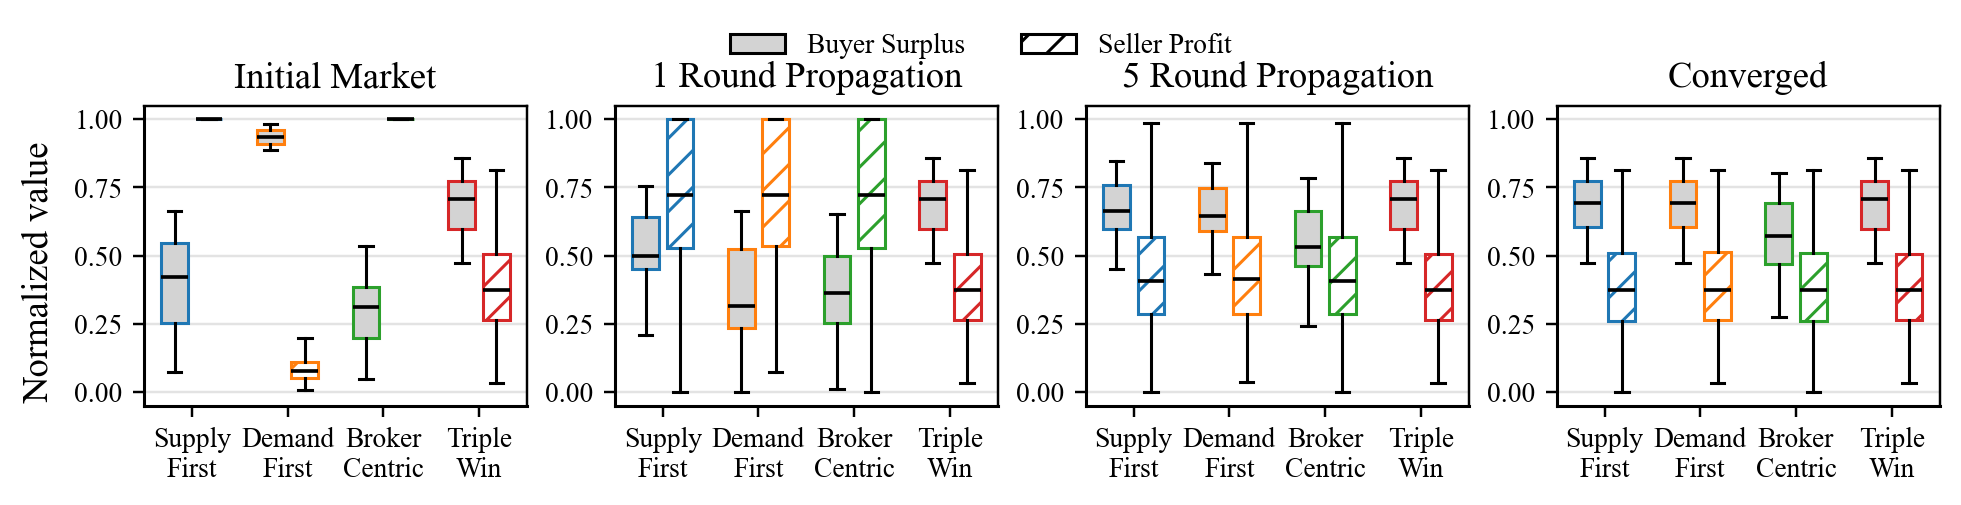

In [65]:
# ============================================================
# 1×4 grouped boxplots (TripleWin fixed across panels)
# No median lines — clean, publication-style layout
# ============================================================
from matplotlib.patches import Patch
import matplotlib as mpl
from matplotlib.lines import Line2D

# --- Style ---
mpl.rcParams.update({
    "figure.dpi": 220,
    "savefig.dpi": 600,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "axes.titlesize": 12, "axes.labelsize": 11,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
    "legend.fontsize": 9,
})

# --- Colors (consistent with scatter palette) ---
method_colors = {
    "SupplyFirst":  plt.cm.tab10(0),  # blue
    "DemandFirst":  plt.cm.tab10(1),  # orange
    "BrokerCentric":plt.cm.tab10(2),  # green
    "TripleWin":    plt.cm.tab10(3),  # red
}
method_order = ["SupplyFirst","DemandFirst","BrokerCentric","TripleWin"]
# # Shorter, multi-line labels for methods
method_labels_pretty = ["Supply\nFirst", "Demand\nFirst", "Broker\nCentric", "Triple\nWin"]

# --- Buyer / Seller vectors ---
def buyer_surplus_vec(p_MtoB_list, buyers):
    vals = []
    for j, blk in enumerate(buyers):
        p, R = p_MtoB_list[j], blk.R
        mask = (p <= R)
        if mask.any():
            u = (p[mask] / R[mask]).astype(float)
            vals.append(np.clip(1.0 - u, 0.0, 1.0))
    return np.concatenate(vals) if vals else np.array([])

def seller_profit_vec(p_DtoM, kappa_D, bar_p_DtoM):
    I_local, J_local = p_DtoM.shape
    vals = []
    for j in range(J_local):
        for i in range(I_local):
            p = float(p_DtoM[i, j]); k = float(kappa_D[i]); b = float(bar_p_DtoM[i, j])
            if p >= k and b > k + 1e-12:
                vals.append(np.clip((p - k) / (b - k), 0.0, 1.0))
    return np.array(vals) if vals else np.array([])

def clone_buyers_with_pinit(buyers_src, p_inits):
    cloned = []
    for j, blk in enumerate(buyers_src):
        cloned.append(BuyerBlock(
            kappa_mb=blk.kappa_mb.copy(),
            p0=blk.p0.copy() if hasattr(blk, "p0") else blk.kappa_mb.copy(),
            R=blk.R.copy(), omega=blk.omega.copy(),
            p_init=p_inits[j].copy()
        ))
    return cloned

# --- Iteration helpers ---
def forward_update_p_MtoB(p_DtoM, buyers, delta):
    out = []
    for j, blk in enumerate(buyers):
        base = (1.0 + float(delta[j])) * float(np.sum(p_DtoM[:, j]))
        pj = blk.kappa_mb + base
        out.append(np.clip(pj, blk.kappa_mb, blk.R).astype(float))
    return out

def backward_update_p_DtoM(p_MtoB, buyers, SV, delta, kappa_D, bar_p):
    I, J = SV.shape
    KD = kappa_D.reshape(-1, 1)
    mat = np.zeros((I, J), dtype=float)
    for j, blk in enumerate(buyers):
        Qj = float(np.sum(blk.omega * p_MtoB[j]))
        mat[:, j] = KD[:, 0] + (SV[:, j] / (1.0 + float(delta[j]))) * Qj
    return np.minimum(bar_p, np.maximum(KD, mat))

def one_round(p_DtoM, buyers, SV, delta, kappa_D, bar_p):
    p_MB = forward_update_p_MtoB(p_DtoM, buyers, delta)
    p_D  = backward_update_p_DtoM(p_MB, buyers, SV, delta, kappa_D, bar_p)
    return p_D, p_MB

def iterate_fixed_point(p_D_init, buyers, SV, delta, kappa_D, bar_p, n_rounds=None, tol=1e-10, max_iter=1000):
    p_D = p_D_init.copy(); last = p_D.copy()
    iters = n_rounds if n_rounds is not None else max_iter
    for _ in range(iters):
        p_D, p_MB = one_round(p_D, buyers, SV, delta, kappa_D, bar_p)
        if n_rounds is None and np.max(np.abs(p_D - last)) <= tol:
            break
        last = p_D.copy()
    return p_D, p_MB

# --- Build stages ---
pD_stage1 = dataseller_max_price.copy()
pMB_stage1 = [blk.kappa_mb.copy() for blk in buyers]
pD_stage2, pMB_stage2 = one_round(pD_stage1, buyers, SV, delta, dataseller_min_price, dataseller_max_price)
pD_stage3, pMB_stage3 = iterate_fixed_point(pD_stage1, buyers, SV, delta, dataseller_min_price, dataseller_max_price, n_rounds=5)
pD_stage4, pMB_stage4 = iterate_fixed_point(pD_stage1, buyers, SV, delta, dataseller_min_price, dataseller_max_price, n_rounds=None, tol=TOL, max_iter=MAX_ITER)
stages = [
    ("Initial Market",        pD_stage1, pMB_stage1),
    ("1 Round Propagation",   pD_stage2, pMB_stage2),
    ("5 Round Propagation",  pD_stage3, pMB_stage3),
    ("Converged",       pD_stage4, pMB_stage4),
]

# --- Compute TripleWin once; reuse fixed point everywhere ---
tw_buyers_ref = clone_buyers_with_pinit(buyers, pMB_stage1)
_, _, _, _, tw_solver = run_method(
    TripleWinPricing, SV, delta, tw_buyers_ref,
    dataseller_min_price, dataseller_max_price, pD_stage1
)
TW_BUYER = buyer_surplus_vec(tw_solver.p_MtoB, tw_solver.buyers)
TW_SELLR = seller_profit_vec(tw_solver.p_DtoM, tw_solver.kappa_D, tw_solver.bar_p_DtoM)

def compute_box_data_for_stage(pD_init, pMB_init):
    stage_buyers = clone_buyers_with_pinit(buyers, pMB_init)
    buyer_data, seller_data = [], []
    for name, cls in methods:
        if name == "TripleWin":
            buyer_data.append(TW_BUYER)
            seller_data.append(TW_SELLR)
            continue
        _, _, _, _, solver = run_method(
            cls, SV, delta, stage_buyers,
            dataseller_min_price, dataseller_max_price, pD_init
        )
        sb = buyer_surplus_vec(solver.p_MtoB, solver.buyers)
        ss = seller_profit_vec(solver.p_DtoM, solver.kappa_D, solver.bar_p_DtoM)
        buyer_data.append(sb[np.isfinite(sb)])
        seller_data.append(ss[np.isfinite(ss)])
    return buyer_data, seller_data

def draw_grouped_boxes(ax, title, buyer_data, seller_data):
    """Draw grouped boxes per method: Buyer (gray) vs Seller (white + hatch)."""
    n = len(method_order)
    x_base = np.arange(1, n + 1, dtype=float)
    offset = 0.18
    pos_buyer  = x_base - offset
    pos_seller = x_base + offset

    common = dict(showfliers=False, widths=0.28, medianprops=dict(linewidth=1.2, color="black"))
    for m_idx, name in enumerate(method_order):
        edge_c = method_colors[name]
        ax.boxplot([buyer_data[m_idx]],  positions=[pos_buyer[m_idx]],  patch_artist=True,
                   boxprops=dict(facecolor="lightgray", edgecolor=edge_c, linewidth=1.0), **common)
        ax.boxplot([seller_data[m_idx]], positions=[pos_seller[m_idx]], patch_artist=True,
                   boxprops=dict(facecolor="white", edgecolor=edge_c, linewidth=1.0, hatch="//"), **common)

    ax.set_xlim(0.5, n + 0.5)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xticks(x_base)
    ax.set_xticklabels(method_labels_pretty, rotation=0, ha="center")
    ax.set_title(title)
    ax.grid(True, axis="y", alpha=0.35)
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(True)
    for spine in ("left", "bottom"):
        ax.spines[spine].set_linewidth(1.0)


# --- Figure: 1×4, 5:4 ratio (2.3×2.0 per subplot) ---
single_w, single_h = 2.2, 2.0
fig, axes = plt.subplots(1, 4, figsize=(single_w*4, single_h), constrained_layout=True)

for ax, (title, pD0, pMB0) in zip(axes, stages):
    buyer_data, seller_data = compute_box_data_for_stage(pD0, pMB0)
    draw_grouped_boxes(ax, title, buyer_data, seller_data)

fig.supylabel("Normalized value")

# Legend (only buyer/seller boxes)
legend_handles = [
    Patch(facecolor="lightgray", edgecolor="black", label="Buyer Surplus"),
    Patch(facecolor="white", edgecolor="black", hatch="//", label="Seller Profit"),
]
fig.legend(legend_handles, [h.get_label() for h in legend_handles],
           loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.10))

# Optional save
fig.savefig("../plots/buyer_seller_boxplot.pdf", format="pdf", bbox_inches="tight")
plt.show()


# # ---------- Figure (2×2 grid, 5:4 ratio per subplot, horizontal labels with line breaks) ----------
# single_w, single_h = 2.3, 2.0  # 5:4 ratio per subplot
# fig, axes = plt.subplots(2, 2, figsize=(single_w*2, single_h*2), constrained_layout=True)
# axes = axes.flatten()

# # Shorter, multi-line labels for methods
# method_labels_pretty = ["Supply\nFirst", "Demand\nFirst", "Broker\nCentric", "Triple\nWin"]

# for idx, (ax, (title, pD0, pMB0)) in enumerate(zip(axes, stages)):
#     buyer_data, seller_data = compute_box_data_for_stage(pD0, pMB0)
#     draw_grouped_boxes(ax, title, buyer_data, seller_data)

# # --- Hide x-axis tick labels for top row ---
# for ax in axes[:2]:
#     ax.set_xticklabels([])
#     ax.set_xlabel("")

# # --- Set pretty method names only on bottom row ---
# for ax in axes[2:]:
#     n = len(method_order)
#     x_base = np.arange(1, n + 1, dtype=float)
#     ax.set_xticks(x_base)
#     ax.set_xticklabels(method_labels_pretty, ha="center", fontsize=10)
#     # ax.set_xlabel("Methods")

# # --- Shared labels ---
# fig.supxlabel("Methods")
# fig.supylabel("Normalized Value")

# # --- Shared legend (buyer gray, seller white + hatched) ---
# legend_handles = [
#     Patch(facecolor="lightgray", edgecolor="black", label="Buyer Surplus"),
#     Patch(facecolor="white", edgecolor="black", hatch="//", label="Seller Profit"),
# ]
# fig.legend(
#     handles=legend_handles,
#     labels=[h.get_label() for h in legend_handles],
#     loc="upper center",
#     ncol=2,
#     frameon=False,
#     bbox_to_anchor=(0.6, 1.08),
# )

# # Optional save
# fig.savefig("../plots/buyer_seller_boxplot.pdf", format="pdf", bbox_inches="tight")
# plt.show()



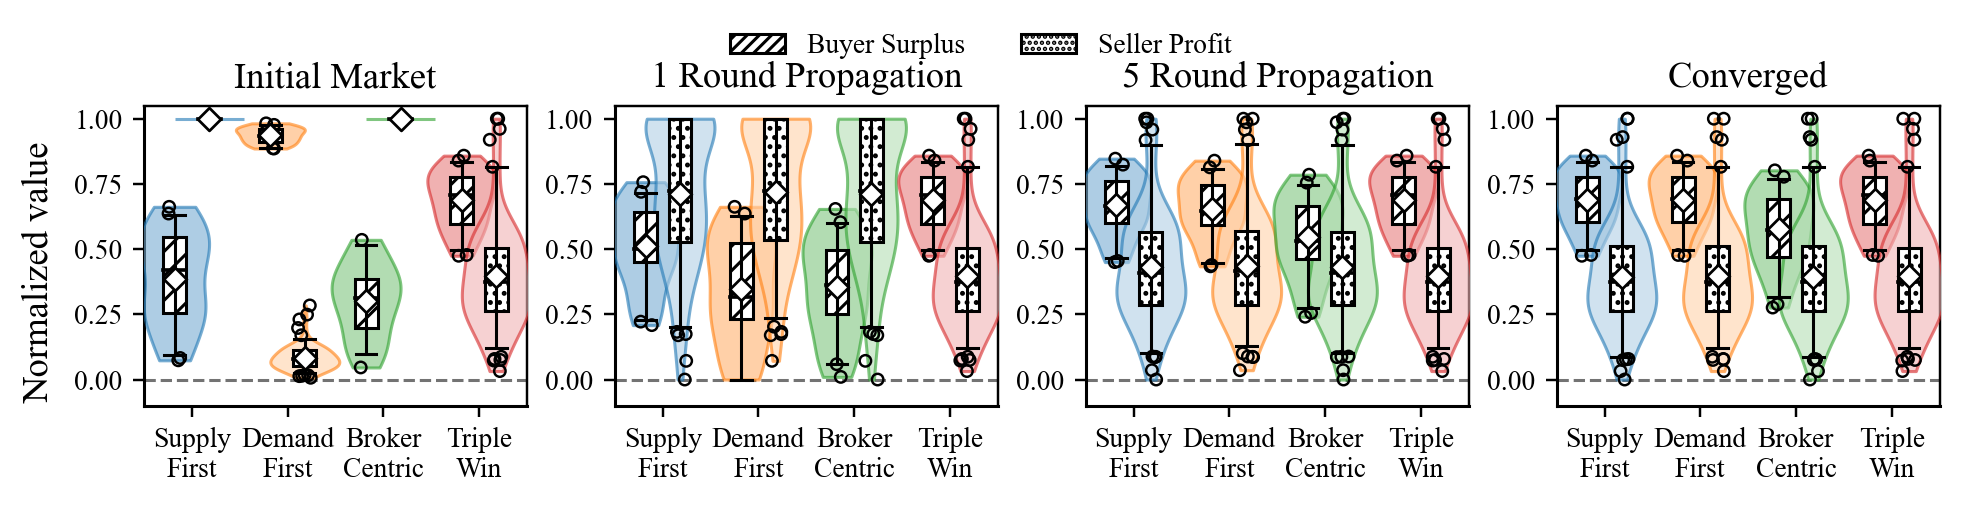

In [66]:
# ============================================================
# 1×4 grouped violin + hatched boxes (hatch ONLY in boxplots)
# Buyer box: '///'   Seller box: '....'
# ============================================================
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from matplotlib import colors as mcolors

# --- Style (Times-like) + crisp hatch lines for print ---
mpl.rcParams.update({
    "figure.dpi": 220,
    "savefig.dpi": 600,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "axes.titlesize": 12, "axes.labelsize": 11,
    "xtick.labelsize": 9,  "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "hatch.linewidth": 1.0,     # make hatches visible
    "hatch.color": "black",
})

def _lighten(color, amount=0.55):
    r, g, b = mcolors.to_rgb(color)
    w = np.array([1.0, 1.0, 1.0])
    c = np.array([r, g, b])
    out = (1 - amount) * c + amount * w
    return tuple(out.clip(0, 1))

def _draw_violin_with_hatched_box(
    ax, data, x0, edge_color, face_color=None,
    vwidth=0.72, boxw=0.24, z=3.0,
    whisker="p5p95",
    box_hatch="///"  # <----- hatch pattern lives ONLY in the box
):
    """
    Violin (pastel fill, colored outline) + HATCHED IQR BOX + median line,
    mean diamond, whiskers/caps, hollow outliers.
    """
    data = np.asarray(data)
    data = data[np.isfinite(data)]
    if data.size == 0:
        return

    # 1) Violin (NO hatch here)
    parts = ax.violinplot([data], positions=[x0], widths=vwidth,
                          showmeans=False, showmedians=False, showextrema=False)
    body = parts["bodies"][0]
    if face_color is None:
        face_color = _lighten(edge_color, 0.55)
    body.set_facecolor(face_color)
    body.set_edgecolor(edge_color)
    body.set_linewidth(1.0)
    body.set_alpha(0.60)
    body.set_zorder(z)

    # 2) Box (IQR) — WITH hatch pattern
    q1, med, q3 = np.percentile(data, [25, 50, 75])
    box = Rectangle(
        (x0 - boxw/2.0, q1), boxw, q3 - q1,
        facecolor="white", edgecolor="black",
        hatch=box_hatch, linewidth=1.0, zorder=z+0.4
    )
    ax.add_patch(box)
    # Median line
    ax.plot([x0 - boxw/2.0, x0 + boxw/2.0], [med, med],
            color="black", linewidth=1.2, zorder=z+0.6)

    # 3) Mean (white diamond)
    mu = float(np.mean(data))
    ax.scatter([x0], [mu], marker="D", s=28, facecolor="white",
               edgecolor="black", linewidth=0.9, zorder=z+0.8)

    # 4) Whiskers + caps
    if whisker == "tukey":
        iqr = q3 - q1
        wlo = np.min(data[data >= q1 - 1.5*iqr]) if np.any(data >= q1 - 1.5*iqr) else data.min()
        whi = np.max(data[data <= q3 + 1.5*iqr]) if np.any(data <= q3 + 1.5*iqr) else data.max()
    else:
        wlo, whi = np.percentile(data, [5, 95])

    ax.vlines(x0, wlo, whi, color="black", linewidth=1.0, zorder=z+0.5)
    capw = boxw * 0.9
    ax.plot([x0 - capw/2.0, x0 + capw/2.0], [wlo, wlo], color="black", linewidth=1.0, zorder=z+0.5)
    ax.plot([x0 - capw/2.0, x0 + capw/2.0], [whi, whi], color="black", linewidth=1.0, zorder=z+0.5)

    # 5) Outliers (hollow)
    lo = data[data < wlo]; hi = data[data > whi]
    if lo.size:
        ax.scatter(x0 + (np.random.rand(lo.size)-0.5)*boxw*0.6, lo,
                   s=14, facecolors="none", edgecolors="black", linewidths=0.8, zorder=z+0.7)
    if hi.size:
        ax.scatter(x0 + (np.random.rand(hi.size)-0.5)*boxw*0.6, hi,
                   s=14, facecolors="none", edgecolors="black", linewidths=0.8, zorder=z+0.7)

def draw_grouped_violinboxes_boxhatched(
    ax, title, buyer_data, seller_data,
    buyer_box_hatch="///", seller_box_hatch="....",
    ylim=(-0.10, 1.05)
):
    """
    For each method: two violins side-by-side (left=Buyer, right=Seller).
    HATCH is applied ONLY to the **box**: Buyer '///', Seller '....'.
    """
    n = len(method_order)
    x_base = np.arange(1, n + 1, dtype=float)
    offset = 0.18

    # Baseline
    ax.axhline(0.0, ls="--", lw=1.0, color="0.45", zorder=0)

    for m_idx, name in enumerate(method_order):
        base_col   = method_colors[name]
        buyer_fill = _lighten(base_col, 0.40)
        seller_fill= _lighten(base_col, 0.65)

        # Buyer (left) — box hatch '///'
        _draw_violin_with_hatched_box(
            ax, buyer_data[m_idx], x_base[m_idx] - offset,
            edge_color=base_col, face_color=buyer_fill,
            vwidth=0.72, boxw=0.24, whisker="p5p95",
            box_hatch=buyer_box_hatch
        )
        # Seller (right) — box hatch '....'
        _draw_violin_with_hatched_box(
            ax, seller_data[m_idx], x_base[m_idx] + offset,
            edge_color=base_col, face_color=seller_fill,
            vwidth=0.72, boxw=0.24, whisker="p5p95",
            box_hatch=seller_box_hatch
        )

    # Cosmetics
    ax.set_xlim(0.5, n + 0.5)
    ax.set_ylim(*ylim)
    ax.set_xticks(x_base)
    ax.set_xticklabels(method_labels_pretty, rotation=0, ha="center")
    ax.set_title(title)
    ax.grid(False)
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(True)
    for spine in ("left", "bottom"):
        ax.spines[spine].set_linewidth(1.0)

# ----------------- Build the figure (1×4 row) -----------------
single_w, single_h = 2.2, 2.0
fig, axes = plt.subplots(1, 4, figsize=(single_w*4, single_h), constrained_layout=True)

for ax, (title, pD0, pMB0) in zip(axes, stages):
    buyer_data, seller_data = compute_box_data_for_stage(pD0, pMB0)
    draw_grouped_violinboxes_boxhatched(
        ax, title, buyer_data, seller_data,
        buyer_box_hatch="///",    # Buyer hatch
        seller_box_hatch="....",  # Seller hatch
        ylim=(-0.10, 1.05)
    )

fig.supylabel("Normalized value")

# Legend showing hatch patterns (box-only)
legend_handles = [
    Patch(facecolor="white", edgecolor="black", hatch="//////",  label="Buyer Surplus"),
    Patch(facecolor="white", edgecolor="black", hatch="......", label="Seller Profit"),
]
fig.legend(legend_handles, [h.get_label() for h in legend_handles],
           loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.10))

fig.savefig("../plots/buyer_seller_boxplot.pdf", format="pdf", bbox_inches="tight")
plt.show()


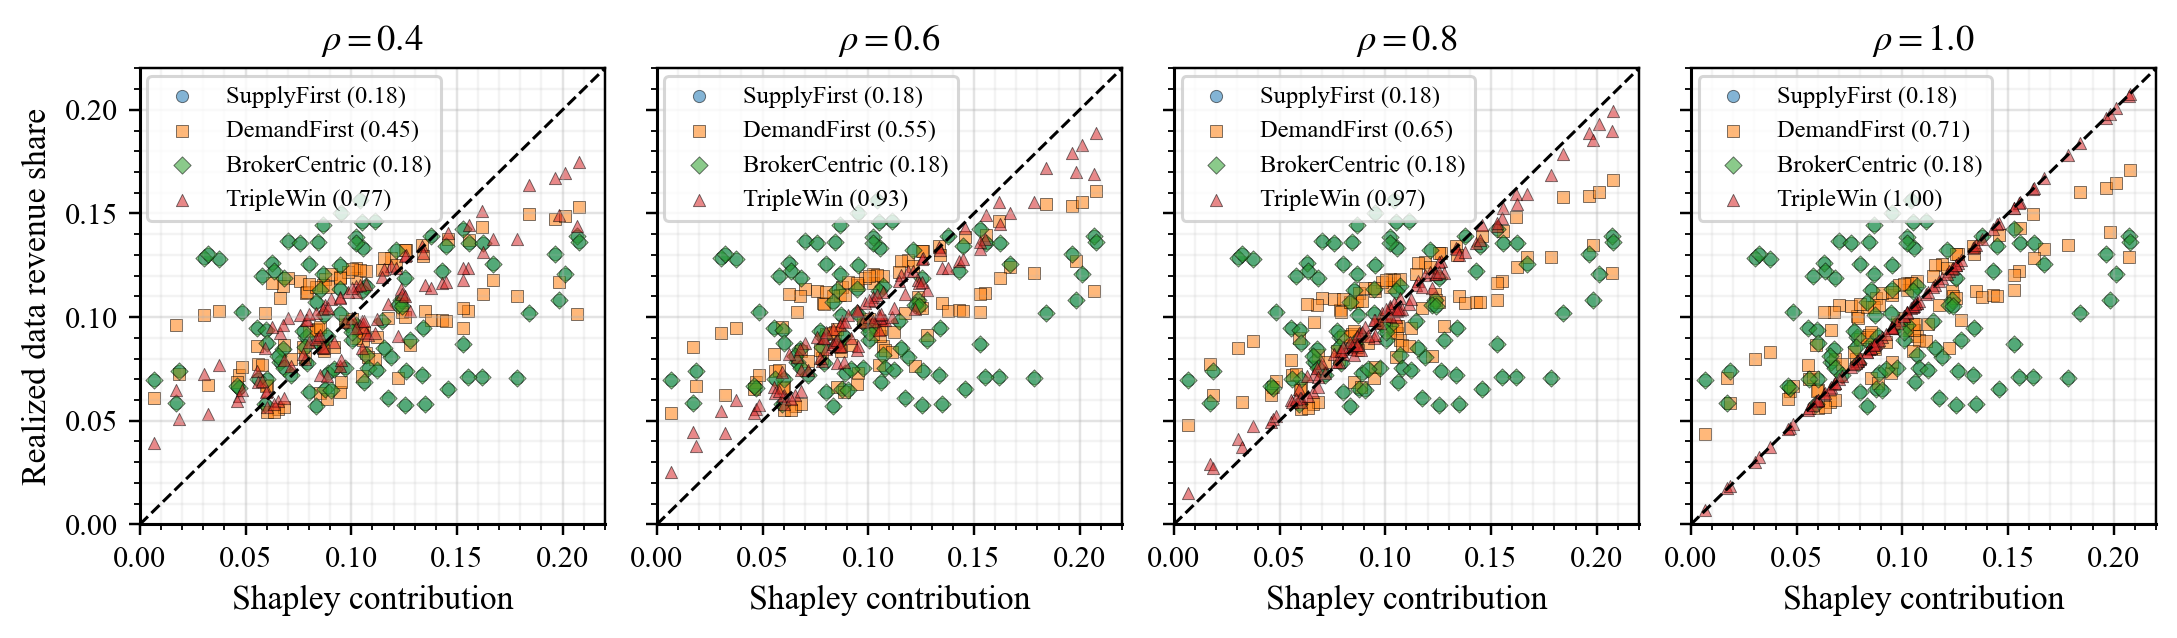

In [67]:
# ============================================================
# Fairness scatter: all four methods × four ρ panels (0.4, 0.6, 0.8, 1.0)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import spearmanr

# ---- If your environment doesn’t yet have them, uncomment:
# from pricing.buyer import BuyerBlock
# from pricing.supply_first import SupplyFirstPricing
# from pricing.demand_first import DemandFirstPricing
# from pricing.broker_centric import BrokerCentricPricingRobust
# from pricing.triple_win import TripleWinPricing

# -----------------------------
# Matplotlib style
# -----------------------------
mpl.rcParams.update({
    "figure.dpi": 220,
    "savefig.dpi": 600,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 9,
})

# -----------------------------
# Helper functions
# -----------------------------
def data_revenue_share(p_DtoM):
    spend = p_DtoM.sum(axis=0)
    out = np.zeros_like(p_DtoM)
    for j in range(p_DtoM.shape[1]):
        if spend[j] > 1e-12:
            out[:, j] = p_DtoM[:, j] / spend[j]
    return out

def fairness_spearman(p_DtoM, SV):
    """Average Spearman correlation (per model)."""
    shares = data_revenue_share(p_DtoM)
    vals = []
    for j in range(SV.shape[1]):
        if shares[:, j].sum() > 0:
            r, _ = spearmanr(shares[:, j], SV[:, j])
            vals.append(r)
    return float(np.nanmean(vals)) if vals else np.nan

def clone_buyers_with_rho(buyers_base, rho):
    """Clone buyers with new uniform ω so Σ ω = rho."""
    new_blocks = []
    for blk in buyers_base:
        K = blk.kappa_mb.size
        omega = np.full(K, rho / K, dtype=float)
        new_blocks.append(
            BuyerBlock(
                kappa_mb=blk.kappa_mb.copy(),
                p0=blk.p0.copy() if hasattr(blk, "p0") else blk.kappa_mb.copy(),
                R=blk.R.copy(),
                omega=omega,
                p_init=blk.p_init.copy() if getattr(blk, "p_init", None) is not None else blk.kappa_mb.copy(),
            )
        )
    return new_blocks

# -----------------------------
# Safe defaults (if not already defined)
# -----------------------------
globals_dict = globals()
if "SV" not in globals_dict:
    np.random.seed(70)
    I, J = 10, 5
    SV_MIN, SV_MAX = 0.02, 0.20
    SV = np.random.uniform(SV_MIN, SV_MAX, size=(I, J))
    SV = SV / SV.sum(axis=0, keepdims=True)
    delta = np.full(J, 0.10)
    dataseller_min_price = np.random.uniform(0.10, 0.40, size=I)
    dataseller_max_price = np.random.uniform(1.50, 4.00, size=(I, J))
    dataseller_init_price = dataseller_max_price.copy()
    BUYER_KAPPA_RANGE = (1.0, 5.0)
    BUYER_R_RANGE = (25.0, 100.0)
    BUYERS_PER_MODEL_RANGE = (1, 5)
    buyers_base = []
    for j in range(J):
        K_j = np.random.randint(BUYERS_PER_MODEL_RANGE[0], BUYERS_PER_MODEL_RANGE[1] + 1)
        kappa_mb = np.random.uniform(*BUYER_KAPPA_RANGE, size=K_j)
        R = np.random.uniform(*BUYER_R_RANGE, size=K_j)
        buyers_base.append(
            BuyerBlock(kappa_mb=kappa_mb, p0=kappa_mb, R=R,
                       omega=np.ones(K_j)/K_j, p_init=kappa_mb.copy())
        )
    TOL = 1e-10
    MAX_ITER = 1000
else:
    buyers_base = buyers

# -----------------------------
# Plot settings
# -----------------------------
rho_list = [0.4, 0.6, 0.8, 1.0]
markers = {"SupplyFirst": "o", "DemandFirst": "s", "BrokerCentric": "D", "TripleWin": "^"}
colors = {
    "SupplyFirst": plt.cm.tab10(0),
    "DemandFirst": plt.cm.tab10(1),
    "BrokerCentric": plt.cm.tab10(2),
    "TripleWin": plt.cm.tab10(3),
}
methods = [
    ("SupplyFirst", SupplyFirstPricing),
    ("DemandFirst", DemandFirstPricing),
    ("BrokerCentric", BrokerCentricPricingRobust),
    ("TripleWin", TripleWinPricing),
]

# -----------------------------
# Figure with 4 panels
# -----------------------------
fig, axes = plt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=True)
x0, x1 = 0.0, 0.22

for ax, rho in zip(axes, rho_list):
    buyers_rho = clone_buyers_with_rho(buyers_base, rho)
    fairness_dict = {}

    # Run each method once
    for name, cls in methods:
        solver = cls(
            shapley_values=SV,
            delta=delta,
            kappa_D=dataseller_min_price,
            buyers=buyers_rho,
            C_var=dataseller_min_price,
            bar_p_DtoM=dataseller_max_price,
            p_DtoM_init=dataseller_init_price,
            tol=TOL, max_iter=MAX_ITER, verbose=False,
        )
        _ = solver.fit()

        shares = data_revenue_share(solver.p_DtoM)
        fairness_dict[name] = fairness_spearman(solver.p_DtoM, SV)

        ax.scatter(
            SV.flatten(), shares.flatten(),
            s=16, alpha=0.55, marker=markers.get(name, "o"),
            color=colors.get(name), edgecolors="black", linewidths=0.3,
            label=f"{name} ({fairness_dict[name]:.2f})"
        )

    ax.plot([x0, x1], [x0, x1], linestyle="--", linewidth=1.0, color="black")
    ax.set_xlim(x0, x1)
    ax.set_ylim(x0, x1)
    ax.set_xlabel("Shapley contribution")
    if ax is axes[0]:
        ax.set_ylabel("Realized data revenue share")
    ax.set_title(fr"$\rho={rho:.1f}$")
    ax.minorticks_on()
    ax.grid(True, which="major", alpha=0.35)
    ax.grid(True, which="minor", alpha=0.15)
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(True)
    for spine in ("left", "bottom"):
        ax.spines[spine].set_linewidth(1.0)
    ax.legend(frameon=True, loc="upper left", ncol=1, fontsize=8, bbox_to_anchor=(-0.01, 1.01),)

# fig.suptitle("Fairness comparison across mechanisms — varying total buyer weight $\\rho$", y=1.02)
fig.tight_layout()
fig.savefig("../plots/data_revenue_vs_shap.pdf", format="pdf", bbox_inches="tight")

plt.show()


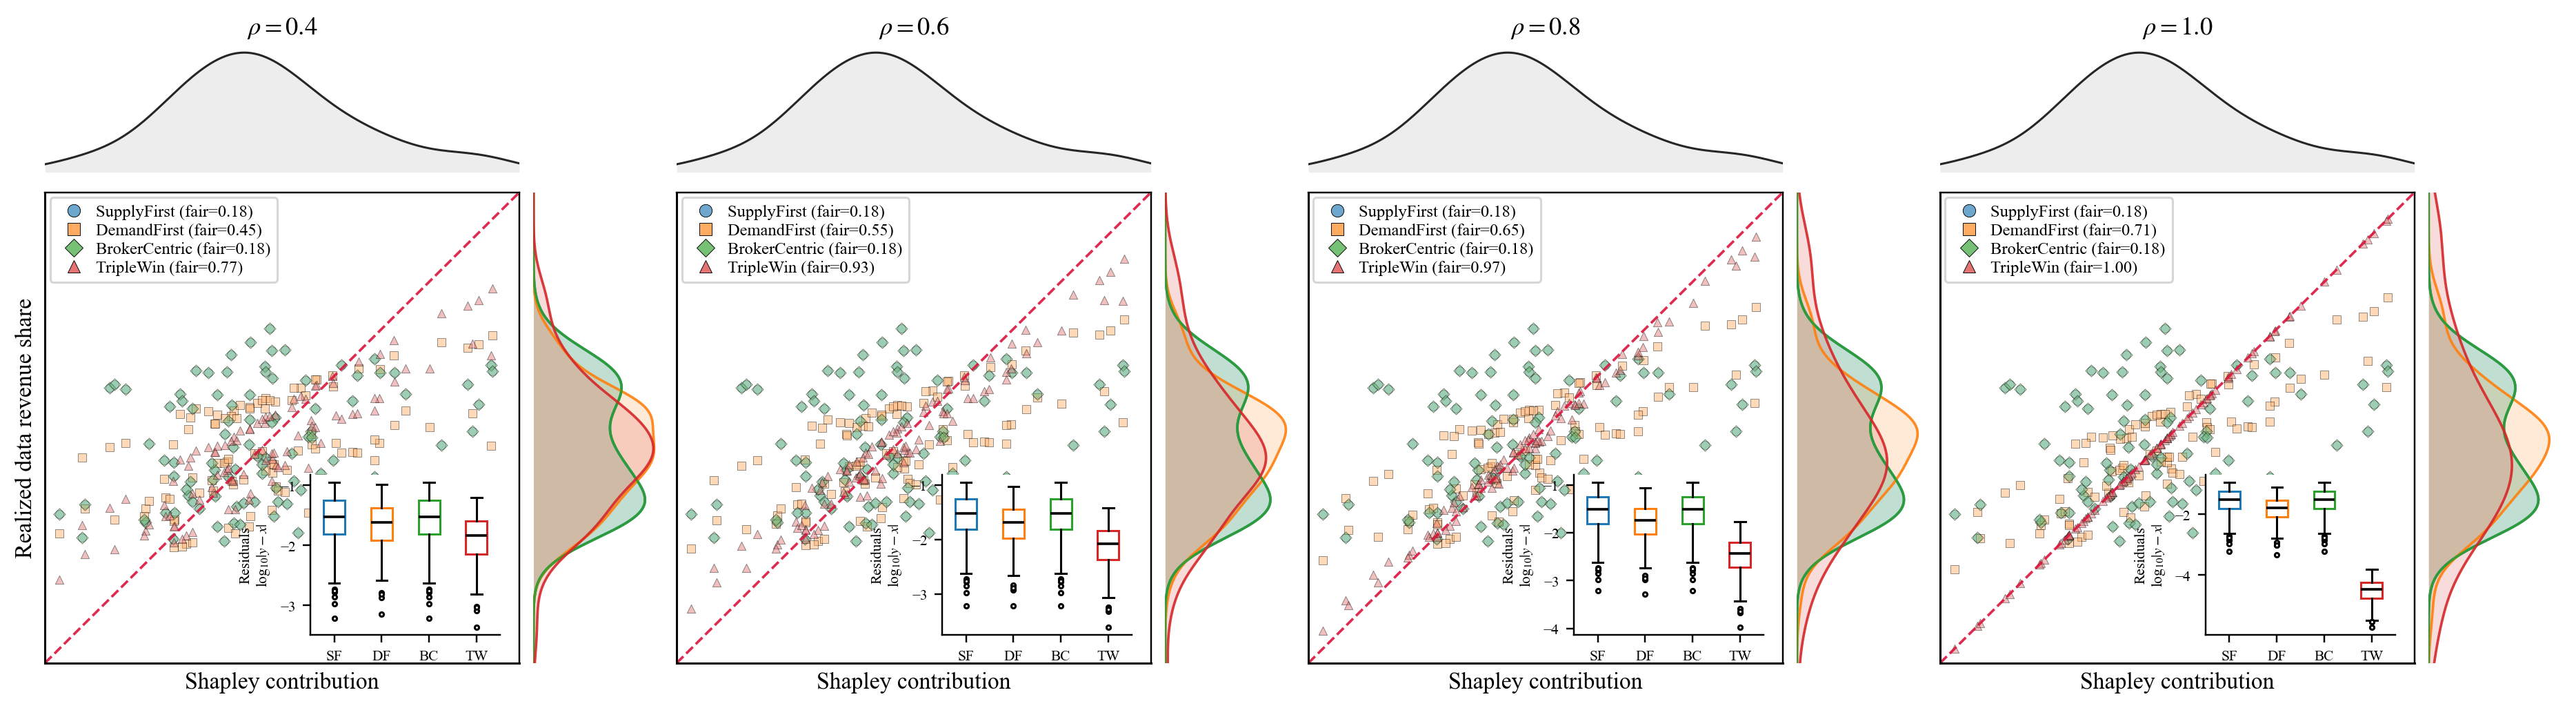

In [68]:
# ============================================================
# Fairness scatter in "jointplot" style for four ρ panels
# (central scatter + top/right KDE + residuals inset)
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import spearmanr, gaussian_kde

# --- helper: lighter color for fills
def _lighten(color, amount=0.6):
    r, g, b, *a = mpl.colors.to_rgba(color)
    w = np.array([1.0, 1.0, 1.0])
    c = np.array([r, g, b])
    out = (1 - amount) * c + amount * w
    return (*out.clip(0, 1), 1.0)

# --- figure layout
rho_list = [0.4, 0.6, 0.8, 1.0]
markers = {"SupplyFirst": "o", "DemandFirst": "s", "BrokerCentric": "D", "TripleWin": "^"}
colors = {
    "SupplyFirst": plt.cm.tab10(0),
    "DemandFirst": plt.cm.tab10(1),
    "BrokerCentric": plt.cm.tab10(2),
    "TripleWin": plt.cm.tab10(3),
}
methods = [
    ("SupplyFirst", SupplyFirstPricing),
    ("DemandFirst", DemandFirstPricing),
    ("BrokerCentric", BrokerCentricPricingRobust),
    ("TripleWin", TripleWinPricing),
]

# each subplot ~2.0×2.0 in; we pad a bit to accommodate insets
fig, axes = plt.subplots(1, 4, figsize=(17, 5), sharex=True, sharey=True)

# main axis limits
x0, x1 = 0.0, 0.22
y0, y1 = 0.0, 0.22

for ax, rho in zip(axes, rho_list):
    # --- buyers for this rho (reuse your helper)
    buyers_rho = clone_buyers_with_rho(buyers_base, rho)

    # containers for marginals & residuals
    x_all = SV.flatten().astype(float)  # common x for all methods
    y_by_method = {}
    res_by_method = {}

    # === MAIN SCATTER ===
    fairness_dict = {}
    for name, cls in methods:
        solver = cls(
            shapley_values=SV,
            delta=delta,
            kappa_D=dataseller_min_price,
            buyers=buyers_rho,
            C_var=dataseller_min_price,
            bar_p_DtoM=dataseller_max_price,
            p_DtoM_init=dataseller_init_price,
            tol=TOL, max_iter=MAX_ITER, verbose=False,
        )
        _ = solver.fit()

        shares = data_revenue_share(solver.p_DtoM).flatten().astype(float)
        y_by_method[name] = shares
        # residuals for inset (log of absolute)
        res_by_method[name] = np.log10(np.abs(shares - x_all) + 1e-6)

        fairness_dict[name] = fairness_spearman(solver.p_DtoM, SV)

        ax.scatter(
            x_all, shares,
            s=16, alpha=0.45,
            marker=markers.get(name, "o"),
            facecolor=_lighten(colors[name], 0.35),
            edgecolor="black", linewidths=0.3,
            label=f"{name} (ρ={rho:.1f}, fair={fairness_dict[name]:.2f})"
        )

    # dashed parity line (red) and subtle dashed grid
    ax.plot([x0, x1], [x0, x1], linestyle="--", linewidth=1.2, color="crimson", alpha=0.9)
    ax.set_xlim(x0, x1); ax.set_ylim(y0, y1)
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle="--", alpha=0.25)
    ax.grid(True, which="minor", linestyle=":", alpha=0.15)

    # axes cosmetics
    for sp in ("top", "right"):
        ax.spines[sp].set_visible(True)
    for sp in ("left", "bottom"):
        ax.spines[sp].set_linewidth(1.0)

    # labels/titles
    ax.set_xlabel("Shapley contribution")
    if ax is axes[0]:
        ax.set_ylabel("Realized data revenue share")
    ax.set_title(fr"$\rho={rho:.1f}$")

    # === TOP MARGINAL (KDE of x / SV) ===
    ax_top = ax.inset_axes([0.0, 1.03, 1.0, 0.28], sharex=ax)
    ax_top.set_facecolor("none")
    grid_x = np.linspace(x0, x1, 256)
    try:
        kde_x = gaussian_kde(x_all)
        dens_x = kde_x(grid_x)
    except Exception:
        # fallback: histogram-like density
        dens_x, edges = np.histogram(x_all, bins=25, range=(x0, x1), density=True)
        grid_x = (edges[:-1] + edges[1:]) / 2.0
    ax_top.fill_between(grid_x, 0, dens_x, color="0.1", alpha=0.08, lw=0)
    ax_top.plot(grid_x, dens_x, color="0.15", lw=1.0)
    ax_top.set_yticks([]); ax_top.set_xticks([])
    for sp in ("top", "right", "left", "bottom"):
        ax_top.spines[sp].set_visible(False)

    # === RIGHT MARGINAL (KDE of y by method) ===
    ax_right = ax.inset_axes([1.03, 0.0, 0.28, 1.0], sharey=ax)
    ax_right.set_facecolor("none")
    dens_max = 0.0
    y_grid = np.linspace(y0, y1, 256)
    # compute and draw method densities
    for name, _ in methods:
        yy = y_by_method[name]
        try:
            kde_y = gaussian_kde(yy)
            dens_y = kde_y(y_grid)
        except Exception:
            dens_y, edges = np.histogram(yy, bins=25, range=(y0, y1), density=True)
            y_grid = (edges[:-1] + edges[1:]) / 2.0
        dens_max = max(dens_max, dens_y.max())
        ax_right.fill_betweenx(y_grid, 0, dens_y,
                               color=_lighten(colors[name], 0.35), alpha=0.25, lw=0)
        ax_right.plot(dens_y, y_grid, color=colors[name], lw=1.2, alpha=0.9)
    ax_right.set_xlim(0, dens_max * 1.10)
    ax_right.set_xticks([]); ax_right.set_yticks([])
    for sp in ("top", "right", "left", "bottom"):
        ax_right.spines[sp].set_visible(False)

    # === RESIDUALS INSET (boxplots of log10 |y-x|) ===
    ax_inset = ax.inset_axes([0.56, 0.06, 0.40, 0.34])  # [x0,y0,w,h] in axes fraction
    data = [res_by_method[name] for name, _ in methods]
    # draw boxplot with thin outlines; themed like the sample figure
    bp = ax_inset.boxplot(
        data, vert=True, patch_artist=True, showfliers=True,
        boxprops=dict(linewidth=1.0, facecolor="white"),
        medianprops=dict(color="black", linewidth=1.2),
        whiskerprops=dict(color="black", linewidth=1.0),
        capprops=dict(color="black", linewidth=1.0),
        flierprops=dict(marker="o", markersize=2.0, markerfacecolor="white", markeredgecolor="black", linestyle="none")
    )
    # color the box edges to match methods
    for patch, (name, _) in zip(bp["boxes"], methods):
        patch.set_edgecolor(colors[name])
        patch.set_facecolor("white")
    ax_inset.set_xticks(range(1, len(methods)+1))
    ax_inset.set_xticklabels(["SF", "DF", "BC", "TW"], fontsize=7)
    ax_inset.set_ylabel("Residuals\nlog$_{10}|y-x|$", fontsize=7)
    ax_inset.tick_params(axis="y", labelsize=7)
    ax_inset.spines["top"].set_visible(False)
    ax_inset.spines["right"].set_visible(False)

    # concise legend (marker samples + fairness)
    handles, labels = [], []
    for name, _ in methods:
        h = plt.Line2D([0], [0],
                       marker=markers[name], linestyle="",
                       markerfacecolor=_lighten(colors[name], 0.35),
                       markeredgecolor="black", markeredgewidth=0.3,
                       markersize=6, label=f"{name} (fair={fairness_dict[name]:.2f})")
        handles.append(h); labels.append(h.get_label())
    ax.legend(handles, labels, frameon=True, loc="upper left",
              fontsize=8, borderaxespad=0.3, handletextpad=0.3, labelspacing=0.2)

fig.tight_layout()
fig.savefig("../plots/data_revenue_vs_shap_jointstyle.pdf", format="pdf", bbox_inches="tight")
plt.show()
